In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [1]:
!pip install --quiet pytorch_lightning 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import pytorch_lightning
from torchvision import transforms
import torch.utils.data
from torch.utils.data import DataLoader
from torch.autograd import Variable

from datetime import datetime
import time
import math

In [2]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Training')
parser.add_argument('--batch-size', type=int, default=128, metavar='N', help='input batch size for training (default: 128)')
parser.add_argument('--test-batch-size', type=int, default=128, metavar='N',
                    help='input batch size for testing (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N', # 1 for test, 10 for train
                    help='number of epochs to train')
parser.add_argument('--num-classes', default=10,
                    help='number of classes in the input dataset')
parser.add_argument('--lr', type=float, default=0.0002, metavar='LR',
                    help='learning rate')
# parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
#                     help='learning rate')  # cascade version, original = 0.01
parser.add_argument('--no-cuda', action='store_true', default=True, # True for NIFGSM only
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--random', default=True,
                    help='random initialization for PGD')
# FGSM: num-steps:1 step-size:0.1099   PGD-20: num-steps:20 step-size:0.005495
parser.add_argument('--epsilon', default=0.1099, # matters for region
                    help='perturbation')
parser.add_argument('--num-steps', default=20,
                    help='perturb number of steps, FGSM: 1, PGD-20: 20')
parser.add_argument('--step-size', default=0.005495,
                    help='perturb step size, FGSM: 0.1099, PGD-20: 0.005495') # change from 0.1099 to 0.005495 3/12/2021

args = parser.parse_args(args=[])
# Device setup
if args.no_cuda:
	device = torch.device("cpu")
else:
	device = torch.device("cuda:0")

In [3]:
print(device)

cpu


In [4]:
# MNIST data
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True)

test_loader = DataLoader(test_set, batch_size=args.batch_size,  shuffle=False, drop_last=True)

train_data, val_data = torch.utils.data.random_split(train_set, [42000, 18000])

train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)

val_loader = DataLoader(val_data, batch_size=args.batch_size, shuffle=False, drop_last=True)

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [7]:
import pickle

# Attack model

In [8]:
class Fnn(nn.Module):
	def __init__(self):
		super(Fnn, self).__init__()
		self.fc1 = nn.Linear(28*28, 128)
		self.fc2 = nn.Linear(128, 64)
		self.fc3 = nn.Linear(64, 32)
		self.fc4 = nn.Linear(32, 10)
	
	def forward(self, x):
		x = self.fc1(x)
		x = F.relu(x)
		x = self.fc2(x)
		x = F.relu(x)
		x = self.fc3(x)
		x = F.relu(x)
		x = self.fc4(x)
		x = F.relu(x)
		x = F.log_softmax(x, dim=1)
		return x

In [9]:
from IPython.utils.path import target_update
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), 28 * 28)

        # clear gradients
        optimizer.zero_grad()

        #print(model(data).shape, target.shape)
        #print(model(data).dtype, target.dtype)
        loss = F.cross_entropy(model(data), target)

        # get gradients and update
        loss.backward()
        optimizer.step()

In [10]:
def eval_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    idx = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), 28 * 28)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            #print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            idx += 1

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
def train_fnn(model):
	model = model.to(device)
 
	for epoch in range(1, args.epochs+1):
		start_time = time.time()
		sgd = optim.SGD(model.parameters(), lr=args.lr)
  
		train(args, model, device, train_loader, sgd, epoch)

		trnloss, trnacc = eval_test(model, device, train_loader)

		print('Epoch ' + str(epoch) + ': ' + str(int(time.time() - start_time)) + 's', end=', ')
		print('trn_loss: {:.4f}, trn_acc: {:.2f}%'.format(trnloss, 100. * trnacc), end='\n')

	return model

In [12]:
# fnn = Fnn().to(device)
# fnn = train_fnn(Fnn())

In [13]:
# torch.save(fnn.state_dict(), "./"+'fnn128'+'.pt')

In [14]:
fnn = Fnn().to(device)

In [15]:
fnn.load_state_dict(torch.load('/content/drive/MyDrive/FYP/fnn.pt'))

<All keys matched successfully>

In [16]:
fnn.eval()

Fnn(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
# tesloss, tesacc = eval_test(fnn, device, test_loader)
# print('test_loss: {:.4f}, trn_acc: {:.2f}%'.format(tesloss, 100. * tesacc), end='\n')

In [18]:
!pip install --quiet captum

In [19]:
import matplotlib.pyplot as plt

# Integrated Gradient

In [ ]:
#train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=False, drop_last=True)

In [20]:
# from copy import deepcopy
from captum.attr import IntegratedGradients

In [21]:
saliency = IntegratedGradients(fnn)

label = []
sample = train_set[0]

for data, target in test_loader:
  #print(target)
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  attribution = saliency.attribute(data, target=target)
  label.append(attribution)

In [ ]:
with open("/content/drive/MyDrive/FYP/label128", "rb") as fp:
  label = pickle.load(fp)

In [ ]:
print(torch.max(label[0]))

tensor(0.4111, device='cuda:0', dtype=torch.float64)


In [ ]:
print(torch.min(label[0]))

tensor(-0.3875, device='cuda:0', dtype=torch.float64)


In [ ]:
# plt.imshow(sample[0].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
plt.imshow(label[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

# Mutated XAI mixture attention mask

In [ ]:
from captum.attr import GuidedBackprop

In [ ]:
# GB = GuidedBackprop(fnn)

# mask = []

# for data, target in train_loader:
#   data, target = data.to(device), target.to(device)
#   data = data.view(data.size(0), 28 * 28)
#   attribution = GB.attribute(data, target=target)
#   mask.append(attribution)

In [ ]:
# with open("/content/drive/MyDrive/FYP/mask128", "wb") as fp:
#   pickle.dump(mask, fp)

In [ ]:
with open("/content/drive/MyDrive/FYP/mask128", "rb") as fp:
  mask = pickle.load(fp)

In [ ]:
plt.imshow(mask[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
from captum.attr import LRP

In [ ]:
lrpa = LRP(fnn)

lrp = []

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  attribution = lrpa.attribute(data, target=target)
  lrp.append(attribution)

In [ ]:
# with open("/content/drive/MyDrive/FYP/lrp128", "wb") as fp:
#   pickle.dump(lrp, fp)

In [ ]:
with open("/content/drive/MyDrive/FYP/lrp128", "rb") as fp:
  lrp = pickle.load(fp)

In [ ]:
plt.imshow(lrp[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
print(torch.max(lrp[0]))

tensor(8.0268, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
print(torch.min(lrp[0]))

tensor(-12.7111, device='cuda:0', grad_fn=<MinBackward1>)


In [ ]:
import random

In [ ]:
def mute(a=.5, b=.5, thr=.5):
  """
  random mutation on weight
  """
  rand = random.random()
  a = rand
  b = 1-a
  if rand<thr:
    #print('mute')
    a = 1-a
    b = 1-b
  #print('a:', a, 'b:', b)
  return (a,b)

lbl = []

#importance mask
for i in range(len(lrp)):
  a, b = mute()
  with torch.no_grad():
    lbl.append(torch.ones_like(lrp[i])-(b*F.normalize(lrp[i])+a*label[i]))

In [ ]:
print(torch.max(lbl[0]))

tensor(1.3471, device='cuda:0', dtype=torch.float64)


In [ ]:
print(torch.min(lbl[0]))

tensor(0.6378, device='cuda:0', dtype=torch.float64)


In [ ]:
print(lbl[0])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)


In [ ]:
print(torch.equal(label[0][0,:], lbl[0][0,:]))

False


In [ ]:
print(torch.equal(lrp[0][0,:], lbl[0][0,:]))

False


In [ ]:
plt.imshow(lbl[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

# Integrated Gradient discover attack

original data XAI

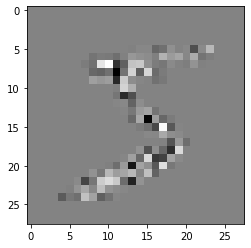

In [ ]:
plt.imshow(label[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
saliency = IntegratedGradients(fnn)

audit1 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox0(idx+1, fnn, data, target)
  attribution = saliency.attribute(adv_data, target=target)
  audit1.append(attribution)

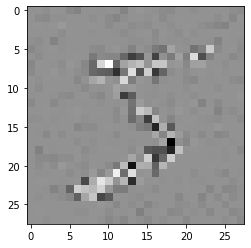

In [ ]:
plt.imshow(audit1[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
umodel = UNet().to(device)
umodel.load_state_dict(torch.load('/content/drive/MyDrive/FYP/u1.1030278996743863.pt'))

<All keys matched successfully>

In [ ]:
umodel.eval()

In [ ]:
saliency = IntegratedGradients(fnn)

audit2 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  #data = data.view(data.size(0), 28 * 28)
  mask = umodel(data)
  adv_data = pgd_whitebox(idx+1, fnn, data.view(data.size(0), 28 * 28), mask.view(mask.size(0), 28 * 28), target, device=device)
  attribution = saliency.attribute(adv_data, target=target)
  audit2.append(attribution)

In [ ]:
plt.imshow(audit2[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
saliency = IntegratedGradients(fnn)

audit3 = []
sample = train_set[0]

for idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox(idx+1, fnn, data, lbl[idx].to(torch.float32), target, device=device)
  attribution = saliency.attribute(adv_data, target=target)
  audit3.append(attribution)

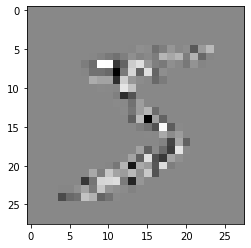

In [ ]:
plt.imshow(audit3[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
#@title XAI(data vs PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit1[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8745, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs GB PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit2[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.9265, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs gene-mean(LRP-IG) PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit3[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.9807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


# .

In [ ]:
#@title XAI(data vs GB PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit2[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8388, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs gene-mean(LRP-IG) PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit3[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8415, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)




---



# attention mask via UModel

In [35]:
def SLU(x, a=.5):
	return torch.max(torch.zeros_like(x),x) + a*torch.sin(x)

In [36]:
def g_normal_(
    tensor, in_c, out_c, kernel_size):
    if 0 in tensor.shape:
        warnings.warn("Initializing zero-element tensors is a no-op")
        return tensor
    std = 2 / ((in_c+out_c)*kernel_size)
    with torch.no_grad():
        return tensor.normal_(0, std)

In [37]:
class Block(nn.Module): # vgg/res inspired
	def __init__(self, in_c, out_c):
		super().__init__()
		self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)
		g_normal_(self.conv1.weight, in_c, out_c, 3) # init
		self.bn = nn.BatchNorm2d(out_c)
		#self.lrelu = nn.LeakyReLU(0.1)
		self.elu = nn.ELU()
		self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
		self.gn = nn.GroupNorm(8, out_c)
		self.dropout = nn.Dropout2d(p=.25)
	
	def forward(self, x):
		#return self.gm(self.lrelu(self.conv2(SLU(self.conv1(x)))))

		y = self.conv1(x)
		identity = y
		y = self.bn(y)
		y = SLU(y)
		y = self.conv2(y)
		y = self.gn(y)
		y = self.dropout(y)
	
		y += identity
		y = self.elu(y)

		return y

class Encoder(nn.Module):
	def __init__(self, chs=(3,64,128,256)):
		super().__init__()
		self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
		#self.pool = nn.MaxPool2d(2)
		self.pool_blks = nn.ModuleList([nn.Conv2d(chs[i+1], chs[i+1], 1, 2, 0) for i in range(len(chs)-1)])
	
	def forward(self, x, cifar=False):
		if not cifar:
			x = x.reshape(args.batch_size, 1, 28, 28)
			x = x.repeat(1, 3, 1, 1)

		ftrs = []
		i = 1
		for (idx, block) in enumerate(self.enc_blocks):	
			x = block(x)
			ftrs.append(x)
			#x = self.pool(x)
			x = self.pool_blks[idx](x)
			i+=1

		return ftrs


class Decoder(nn.Module):
	def __init__(self, chs=(256, 128, 64)):
		super().__init__()
		self.chs = chs
		self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2, 0) for i in range(len(chs)-1)])
		self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])


	def forward(self, x, encoder_features, cifar=False):
		for i in range(len(self.chs)-1):
			x = self.upconvs[i](x)
			enc_ftrs = self.crop(encoder_features[i], x)
			x = torch.cat([x, enc_ftrs], dim=1)
			x = self.dec_blocks[i](x)
		
		return x

	def crop(self, enc_ftrs, x):
		_, _, H, W = x.shape
		enc_ftrs = torchvision.transforms.CenterCrop([H,W])(enc_ftrs)
		return enc_ftrs

class UNet(nn.Module):
	def __init__(self, enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=1, retain_dim=False, out_sz=(28,28)):
		super().__init__()
		self.encoder = Encoder(enc_chs)
		self.decoder = Decoder(dec_chs)
		self.head = nn.Conv2d(dec_chs[-1], num_class, 1)
		self.retain_dim = retain_dim

	def forward(self, x):
		enc_ftrs = self.encoder(x)
		out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
		out = self.head(out)

		if self.retain_dim:
			out = F.interpolate(out, out_sz)

		return out
	

In [ ]:
eps=.3

In [ ]:
def BYOL(x, xp):
		return torch.sum(2-2*torch.nan_to_num(torch.div(torch.stack((x,xp)), eps+torch.norm(x.float(), p=float('inf')))*torch.norm(xp.float(), p=float('inf'))), dim=None)

# Saliency MyLoss train

In [ ]:
def pgd_whitebox(bi, model, X, mask, y, epsilon=args.epsilon, num_steps=args.num_steps, step_size=args.step_size, device=device):

	X_pgd = Variable(X.data, requires_grad=True)
 
	if args.random: 
		noise = torch.clamp(mask, -epsilon, epsilon).to(device) # XAI mask
		X_pgd = Variable(X_pgd.data + noise, requires_grad=True)
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = F.cross_entropy(model(X_pgd), y)
			if not bi % 200: lss.append(loss.item())
		loss.backward()

		eta = torch.clamp(mask, -step_size, step_size) * X_pgd.grad.data.sign() #grad for patch only # XAI mask based pixel wise step size
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
	et = time.time()
	#print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	if not bi % 200: plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')
	return X_pgd

In [ ]:
def pgd_whitebox0(bi, model, X, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device, cifar=False):
	out = model(X)
	X_pgd = Variable(X.data, requires_grad=True)
	if args.random:
		random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
		X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)
  
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = nn.CrossEntropyLoss()(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		eta = step_size * X_pgd.grad.data.sign()
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

	et = time.time()
	#print('pgd time: ', et-st, ' s')
	#st = [i for i in range(20)]
	#plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')

	return X_pgd

In [ ]:
iters = len(train_loader)
from datetime import datetime
# Getting the current date and time
dt = datetime.now()
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [ ]:
def adv(model, idx, data, target, device=device):

    model.eval().to(device)
    fnn.eval().to(device)
    correct = 0
    
    with torch.no_grad():
      data = data.to(device)
      target = target.to(device)
      buf = model(data)
      adv = pgd_whitebox(idx, fnn, data.view(data.size(0), 28*28), buf.view(buf.size(0), 28*28), target,\
                         device=device)
      output = fnn(adv)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
            
    accuracy = correct / len(target)
    return accuracy

In [ ]:
def adv0(model, idx, data, target, device=device):

    model.eval().to(device)
    fnn.eval().to(device)
    correct = 0
    
    with torch.no_grad():
      data = data.to(device)
      target = target.to(device)
      adv = pgd_whitebox0(idx, fnn, data.view(data.size(0), 28*28), target, device=device)
      output = fnn(adv)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
            
    accuracy = correct / len(target)
    return accuracy

In [ ]:
def train_model(epoch=args.epochs):
	lbd=1e-2
	
	loss_t = []
	loss_v = []
	
	k = torch.Tensor([1,1,1])
	l1loss = nn.L1Loss()
	#l1loss = nn.CrossEntropyLoss()
									
	model = UNet().to(device)
	
	model_name = str(datetime.now()) + '.pt'

	#early_stopping = EarlyStopping(patience=15, verbose=True)
 
	for epoch in range(1, epoch+1):
		model.train()
	
		start_time = time.time()
		optimizer = optim.SGD(model.parameters() , lr=args.lr)
		scheduler = CosineAnnealingWarmRestarts(optimizer, int(iters/2))
	
		
		lb = lbl
		
		total_l_t = 0.0
		total_l_v = 0.0

		for batch_idx, (data, target) in enumerate(train_loader):
			data = data.to(device)
			target = target.to(device)   

			optimizer.zero_grad()

			# self loss itr 3
			mask = model(data)
			loss = k[0]*l1loss(pgd_whitebox(batch_idx, fnn, data.view(data.size(0), 28*28), mask.view(mask.size(0), 28*28), \
			                              target, device=device), data.view(data.size(0), 28*28)).requires_grad + \
																		k[1]*l1loss(mask.view(mask.size(0), 28*28), lbl[batch_idx]) + k[2]*(
																				adv(model, batch_idx, data, target)-adv0(model, batch_idx, data, target)
																		)

			loss.retain_grad()
			loss /= args.batch_size
			loss.backward()
	 
			loss += lbd*loss.grad
			
			
			total_l_t += loss.item()
	 
			
			optimizer.step()
			scheduler.step(epoch + batch_idx / iters)

		loss_t.append(total_l_t/len(train_loader))
	
		for batch_idx, (data, target) in enumerate(val_loader):
			model.eval()
			data = data.to(device)
			target = target.to(device) 

			mask = model(data)
			loss = k[0]*l1loss(pgd_whitebox(batch_idx, fnn, data.view(data.size(0), 28*28), mask.view(mask.size(0), 28*28), \
			                              target, device=device), data.view(data.size(0), 28*28)).requires_grad + \
																		k[1]*l1loss(mask.view(mask.size(0), 28*28), lbl[batch_idx]) + k[2]*(
																				adv(model, batch_idx, data, target)-adv0(model, batch_idx, data, target)
																		)
			total_l_v += loss.item()
	 
		loss_v.append(total_l_v/len(val_loader))
	 
		# early_stopping(loss_v[0], model)
	
		# if early_stopping.early_stop:
		# 	print("Early stopping")
		# 	break
		
		print('Epoch ' + str(epoch) + ': ' + str(int(time.time() - start_time)) + 's', \
		      'val loss', float(loss_v[-1]))
	
	torch.save(model.state_dict(), "/content/drive/MyDrive/FYP/"+'u'+str(loss_v[-1])+'.pt')

	return model

In [ ]:
torch.autograd.set_detect_anomaly(True)

# Runs

Epoch 1: 446s val loss 1.1778593572533262
Epoch 2: 436s val loss 1.1539802672398765
Epoch 3: 452s val loss 1.1390762534633996
Epoch 4: 436s val loss 1.128444440222264
Epoch 5: 433s val loss 1.1205452645162384


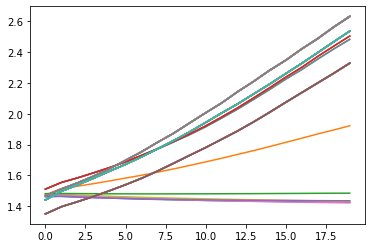

In [ ]:
#@title 5 epoch already good
umodel = train_model(5)

Epoch 1: 418s val loss 1.192833474477728
Epoch 2: 417s val loss 1.1527210271893917
Epoch 3: 409s val loss 1.1276541233159196
Epoch 4: 405s val loss 1.1114904032266644
Epoch 5: 406s val loss 1.1029349589012938


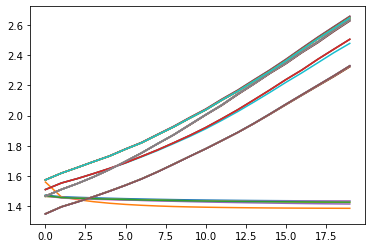

In [ ]:
umodel = train_model(5)

Epoch 1: 426s val loss 1.2075706731668578
Epoch 2: 434s val loss 1.164285443234178
Epoch 3: 435s val loss 1.1376415218888758
Epoch 4: 437s val loss 1.1194555422971921
Epoch 5: 433s val loss 1.1072013017570974
Epoch 6: 431s val loss 1.1002269751237788
Epoch 7: 429s val loss 1.0939016168167366
Epoch 8: 427s val loss 1.09087771816802
Epoch 9: 427s val loss 1.0874716414491699
Epoch 10: 428s val loss 1.0848626516738975
Epoch 11: 428s val loss 1.084208944022314
Epoch 12: 424s val loss 1.0833073369209585
Epoch 13: 428s val loss 1.083870274374459
Epoch 14: 429s val loss 1.0844474649462836
Epoch 15: 426s val loss 1.0844793534237986
Epoch 16: 426s val loss 1.0848609196450258
Epoch 17: 426s val loss 1.085631653369253
Epoch 18: 426s val loss 1.0859762947506806
Epoch 19: 427s val loss 1.087054383183328
Epoch 20: 425s val loss 1.0880657668981037
Epoch 21: 426s val loss 1.0888113632169563
Epoch 22: 427s val loss 1.08970993148121
Epoch 23: 427s val loss 1.0904903816419123
Epoch 24: 425s val loss 1.090

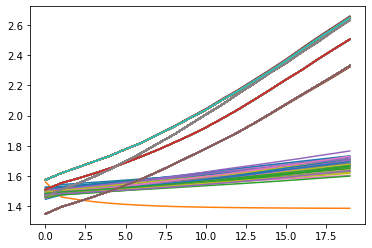

In [ ]:
umodel = train_model(50)

Epoch 1: 437s val loss 1.1536750294216338
Epoch 2: 441s val loss 1.1132683203280243
Epoch 3: 450s val loss 1.0959419859285329
Epoch 4: 445s val loss 1.0851952252627475
Epoch 5: 444s val loss 1.0816575794074839
Epoch 6: 444s val loss 1.0777363509284437
Epoch 7: 444s val loss 1.076565994401676
Epoch 8: 442s val loss 1.0752149662910782
Epoch 9: 447s val loss 1.0747385558656473
Epoch 10: 445s val loss 1.0752419870736165
Epoch 11: 444s val loss 1.0756764499274085
Epoch 12: 445s val loss 1.0758572348093478
Epoch 13: 444s val loss 1.0758692565758732
Epoch 14: 442s val loss 1.0761781591080697
Epoch 15: 443s val loss 1.0764254108253624
Epoch 16: 441s val loss 1.0771118276225122
Epoch 17: 467s val loss 1.0778973260865454
Epoch 18: 461s val loss 1.0796713083249476
Epoch 19: 450s val loss 1.0803549078361536
Epoch 20: 443s val loss 1.0817201749095016
Epoch 21: 437s val loss 1.0824599455906816
Epoch 22: 437s val loss 1.083958525568371
Epoch 23: 437s val loss 1.084271591171841
Epoch 24: 435s val loss

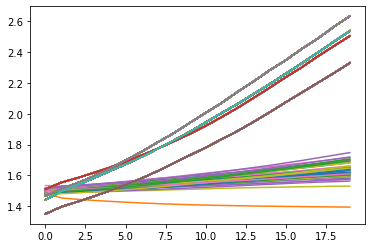

In [ ]:
umodel = train_model(50)

# U mask

In [ ]:
umodel.eval()
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:  
    data = data.to(device)
    target = target.to(device)   
    # self loss itr 2
    mask = umodel(data)

print(mask.shape)
print(mask[0])

torch.Size([128, 1, 28, 28])
tensor([[[0.8035, 0.9354, 0.9420, 1.0207, 0.9570, 1.0177, 1.0244, 1.0188,
          0.9749, 1.0581, 1.0096, 1.0112, 0.9968, 1.0432, 1.0128, 1.0916,
          1.0124, 1.0312, 1.0075, 1.0388, 1.0543, 1.0056, 1.0137, 0.9863,
          0.9588, 1.0099, 0.9595, 0.7913],
         [0.8514, 0.9995, 0.9737, 0.9989, 0.9948, 0.9469, 0.9921, 0.9818,
          1.0194, 0.9600, 1.0875, 0.9792, 1.0370, 0.9561, 0.9652, 1.0299,
          1.0089, 0.9529, 0.9897, 0.9892, 1.0097, 0.9856, 0.9981, 1.0301,
          0.9719, 1.0541, 0.9975, 1.0120],
         [0.9626, 0.9907, 1.0054, 1.0296, 1.0013, 0.9696, 1.0221, 0.9643,
          0.9655, 1.0230, 0.9013, 1.0017, 0.8433, 1.0391, 0.9278, 1.0742,
          0.9584, 1.0215, 1.0110, 1.0945, 1.0871, 1.0929, 1.0777, 0.9890,
          0.9510, 1.0747, 1.0014, 0.9781],
         [0.9840, 1.0169, 1.0645, 1.1103, 1.0396, 1.0502, 1.1237, 0.9620,
          0.9096, 0.8504, 0.9531, 0.8945, 0.9563, 0.9453, 1.0215, 0.9380,
          1.0064, 0.9617, 1.

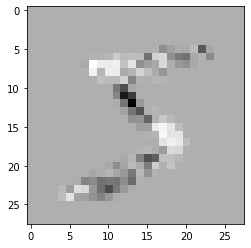

In [ ]:
plt.imshow(lbl[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

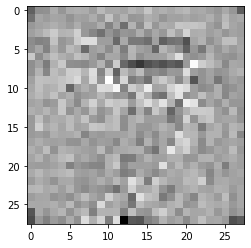

In [ ]:
plt.imshow(mask[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

# New Section

In [ ]:
umodel.eval()
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:  
    data = data.to(device)
    target = target.to(device)   
    # self loss itr 2
    mask = umodel(data)

print(mask.shape)
print(mask[0])

torch.Size([128, 1, 28, 28])
tensor([[[0.7261, 0.9148, 0.9606, 0.9233, 1.0009, 0.9396, 0.9674, 0.8709,
          1.0133, 0.9395, 0.9861, 0.9081, 1.0131, 0.9464, 0.9826, 0.9163,
          1.0072, 0.9360, 0.9837, 0.9122, 1.0086, 0.9734, 0.9694, 0.9454,
          0.9946, 0.9211, 0.7702, 0.3650],
         [0.9258, 0.9666, 1.0222, 0.9778, 1.0292, 1.0296, 1.0059, 0.9794,
          0.9960, 1.0259, 1.0179, 0.9838, 1.0183, 1.0130, 1.0211, 0.9771,
          1.0116, 1.0192, 1.0224, 0.9698, 0.9949, 1.0207, 1.0111, 0.9950,
          0.9957, 0.9464, 0.9046, 0.4962],
         [0.8499, 0.9739, 1.0132, 0.9640, 0.9901, 0.9991, 0.9882, 1.0062,
          1.0222, 1.0143, 0.9992, 0.9811, 1.0094, 1.0105, 1.0129, 0.9914,
          1.0136, 1.0209, 1.0024, 1.0039, 1.0222, 1.0270, 0.9865, 1.0004,
          1.0105, 1.0355, 1.0062, 0.6516],
         [0.9389, 0.9706, 0.9827, 1.0148, 1.0040, 0.9864, 1.0153, 0.9730,
          0.9875, 1.0253, 1.0277, 0.9889, 0.9858, 1.0231, 1.0286, 0.9797,
          0.9715, 1.0217, 1.

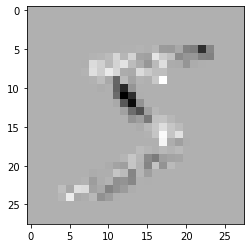

In [ ]:
plt.imshow(lbl[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

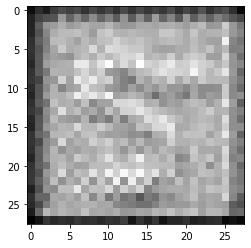

In [ ]:
plt.imshow(buf[1][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

# New Section

In [ ]:
umodel.eval()
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:  
    data = data.to(device)
    target = target.to(device)   
    # self loss itr 2
    mask = umodel(data)

print(mask.shape)
print(mask[0])

torch.Size([128, 1, 28, 28])
tensor([[[0.6433, 0.8228, 0.9558, 1.0097, 0.9417, 0.9858, 1.0117, 0.9842,
          1.0367, 1.0029, 0.9953, 1.0346, 0.9827, 1.0182, 1.0334, 1.0707,
          0.9888, 1.0342, 0.9677, 0.9992, 0.9357, 1.0385, 1.0042, 0.9735,
          0.9369, 0.9696, 0.9003, 0.7632],
         [0.8306, 0.9049, 0.9414, 1.0361, 1.0395, 0.9840, 1.0238, 1.0347,
          0.9815, 1.0419, 1.0548, 1.0524, 0.9900, 0.9695, 1.0920, 1.0226,
          1.0253, 0.9875, 1.0844, 1.0253, 0.9735, 1.0322, 1.0527, 1.0239,
          0.9873, 1.0174, 1.0702, 0.9340],
         [0.9652, 1.0148, 1.0292, 0.9964, 1.0257, 1.0647, 1.0074, 0.9586,
          1.0552, 0.9911, 0.9873, 0.9985, 0.9974, 1.0043, 0.9724, 0.9993,
          1.0601, 1.0160, 0.9754, 1.0221, 1.0040, 1.0659, 0.9575, 1.0015,
          1.0196, 1.0504, 1.0171, 1.0409],
         [0.9586, 1.0366, 1.0669, 1.0717, 1.0433, 0.9755, 1.0255, 0.9856,
          0.9523, 0.9781, 0.9981, 0.9318, 1.0098, 0.9342, 1.0376, 0.9399,
          1.0199, 0.9144, 1.

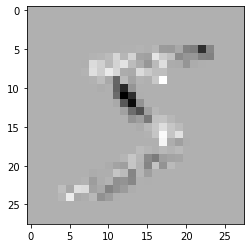

In [ ]:
plt.imshow(lbl[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

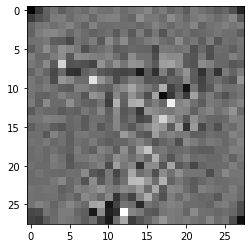

In [ ]:
plt.imshow(mask[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

# mixture mask attack Evaluate

In [ ]:
#@title save data txt
import numpy as np
np.savetxt('my_file.txt', lbl[0][0,:].cpu().detach().numpy())

In [ ]:
def pgd_whitebox(bi, model, X, mask, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device):

	X_pgd = Variable(X.data, requires_grad=True)
 
	if args.random:
		noise = torch.clamp(mask, -epsilon, epsilon).to(device) # XAI mask
		X_pgd = Variable(X_pgd.data + noise, requires_grad=True)
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = F.cross_entropy(model(X_pgd), y)
			if not bi % 200: lss.append(loss.item())
		loss.backward()

		eta = torch.clamp(mask, -step_size, step_size) * X_pgd.grad.data.sign() #grad for patch only # XAI mask based pixel wise step size
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
	et = time.time()
	print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	if not bi % 200: plt.plot(st, lss)
	if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')
	return X_pgd

In [ ]:
def pgd_whitebox0(bi, model, X, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device, cifar=False):
	out = model(X)
	X_pgd = Variable(X.data, requires_grad=True)
	if args.random:
		random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
		X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)
  
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = nn.CrossEntropyLoss()(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		eta = step_size * X_pgd.grad.data.sign()
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

	et = time.time()
	print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	if not bi % 200: plt.plot(st, lss)
	if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')

	return X_pgd

In [ ]:
def pgd_eval_adv_test(device, test_loader):

    fnn.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            print(batch_idx)
            data, target = data.to(device), target.to(device)

            data = data.view(data.size(0), 28 * 28)
            adv_data = pgd_whitebox0(batch_idx, fnn, data, target, device=device)

            output = fnn(adv_data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

0
pgd time:  0.2492682933807373  s
0 misclassified: 103
1
pgd time:  0.1479802131652832  s
1 misclassified: 101
2
pgd time:  0.15346813201904297  s
2 misclassified: 102
3
pgd time:  0.15243268013000488  s
3 misclassified: 107
4
pgd time:  0.30528712272644043  s
4 misclassified: 99
5
pgd time:  0.3077380657196045  s
5 misclassified: 105
6
pgd time:  0.18210959434509277  s
6 misclassified: 103
7
pgd time:  0.14175772666931152  s
7 misclassified: 102
8
pgd time:  0.14792585372924805  s
8 misclassified: 109
9
pgd time:  0.15200471878051758  s
9 misclassified: 101
10
pgd time:  0.15281295776367188  s
10 misclassified: 112
11
pgd time:  0.14810729026794434  s
11 misclassified: 104
12
pgd time:  0.1466960906982422  s
12 misclassified: 106
13
pgd time:  0.14714431762695312  s
13 misclassified: 105
14
pgd time:  0.15537548065185547  s
14 misclassified: 107
15
pgd time:  0.25507545471191406  s
15 misclassified: 113
16
pgd time:  0.31721043586730957  s
16 misclassified: 104
17
pgd time:  0.252991

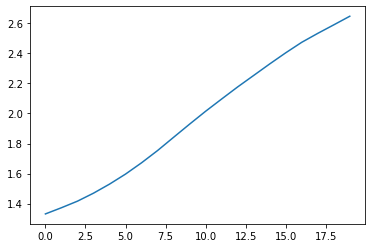

In [ ]:
advloss, advacc = pgd_eval_adv_test(device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

In [ ]:
def lbl_eval_adv_test(mask, device, test_loader):

    fnn.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            data = data.view(data.size(0), 28*28)
            #print(data.dtype, mask[batch_idx].dtype)
            adv_data = pgd_whitebox(batch_idx, fnn, data, mask[batch_idx].to(torch.float32), target, device=device)

            #adv_data = adv_data.view(adv_data.size(0), 28*28)
            output = fnn(adv_data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

pgd time:  0.15489602088928223  s
0 misclassified: 101
pgd time:  0.14969134330749512  s
1 misclassified: 97
pgd time:  0.1731550693511963  s
2 misclassified: 97
pgd time:  0.3310368061065674  s
3 misclassified: 102
pgd time:  0.3050508499145508  s
4 misclassified: 96
pgd time:  0.16005659103393555  s
5 misclassified: 100
pgd time:  0.13814544677734375  s
6 misclassified: 96
pgd time:  0.1365370750427246  s
7 misclassified: 100
pgd time:  0.14117097854614258  s
8 misclassified: 103
pgd time:  0.15344667434692383  s
9 misclassified: 97
pgd time:  0.141218900680542  s
10 misclassified: 107
pgd time:  0.18911147117614746  s
11 misclassified: 96
pgd time:  0.15066099166870117  s
12 misclassified: 103
pgd time:  0.16179871559143066  s
13 misclassified: 102
pgd time:  0.2844674587249756  s
14 misclassified: 103
pgd time:  0.3143937587738037  s
15 misclassified: 109
pgd time:  0.23806047439575195  s
16 misclassified: 99
pgd time:  0.1381831169128418  s
17 misclassified: 103
pgd time:  0.14427

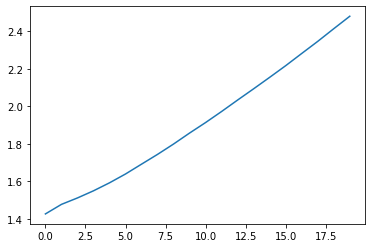

In [ ]:
advloss, advacc = lbl_eval_adv_test(lbl, device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

# Model eva

In [ ]:
#@title query-efficient
#data = data.view(data.size(0), 28*28)
buf = []
umodel.eval()
with torch.no_grad():
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    buf.append(umodel(data))

In [ ]:
print(buf[0].shape)

torch.Size([512, 1, 28, 28])


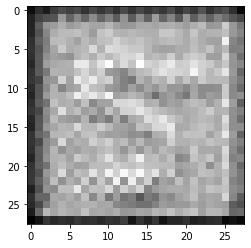

In [ ]:
plt.imshow(buf[1][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
plt.imshow(buf[1][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

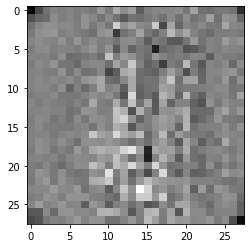

In [ ]:
plt.imshow(buf[1][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [ ]:
print(torch.max(buf[1][0,:].cpu()))
print(torch.min(buf[1][0,:].cpu()))

tensor(1.2269)
tensor(0.5578)


In [ ]:
def eval_adv_test(model, device, test_loader):

    model.eval().to(device)
    fnn.eval().to(device)
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            buf = model(data)
            adv = pgd_whitebox(batch_idx, fnn, data.view(data.size(0), 28*28), buf.view(buf.size(0), 28*28), target, device=device)
            output = fnn(adv)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

0 misclassified: 96
1 misclassified: 90
2 misclassified: 87
3 misclassified: 88
4 misclassified: 95
5 misclassified: 90
6 misclassified: 91
7 misclassified: 85
8 misclassified: 104
9 misclassified: 92
10 misclassified: 91
11 misclassified: 94
12 misclassified: 92
13 misclassified: 96
14 misclassified: 89
15 misclassified: 86
16 misclassified: 80
17 misclassified: 88
18 misclassified: 88
19 misclassified: 97
20 misclassified: 91
21 misclassified: 94
22 misclassified: 91
23 misclassified: 89
24 misclassified: 98
25 misclassified: 95
26 misclassified: 93
27 misclassified: 95
28 misclassified: 82
29 misclassified: 90
30 misclassified: 97
31 misclassified: 98
32 misclassified: 97
33 misclassified: 91
34 misclassified: 86
35 misclassified: 90
36 misclassified: 82
37 misclassified: 99
38 misclassified: 101
39 misclassified: 98
40 misclassified: 99
41 misclassified: 88
42 misclassified: 80
43 misclassified: 88
44 misclassified: 92
45 misclassified: 101
46 misclassified: 90
47 misclassified: 81

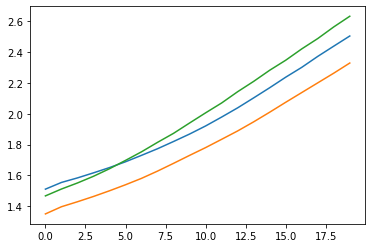

In [ ]:
model = umodel

# model.load_state_dict(torch.load(model_name))

sgd = optim.SGD(model.parameters(), lr=args.lr)


advloss, advacc = eval_adv_test(model, device, train_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

pgd time:  0.1673891544342041  s
0 misclassified: 101
pgd time:  0.3240671157836914  s
1 misclassified: 97
pgd time:  0.31192803382873535  s
2 misclassified: 97
pgd time:  0.2307429313659668  s
3 misclassified: 102
pgd time:  0.15841078758239746  s
4 misclassified: 96
pgd time:  0.15706110000610352  s
5 misclassified: 100
pgd time:  0.1551671028137207  s
6 misclassified: 96
pgd time:  0.16320276260375977  s
7 misclassified: 100
pgd time:  0.16027522087097168  s
8 misclassified: 103
pgd time:  0.18323206901550293  s
9 misclassified: 97
pgd time:  0.17118096351623535  s
10 misclassified: 107
pgd time:  0.1638178825378418  s
11 misclassified: 96
pgd time:  0.16856694221496582  s
12 misclassified: 103
pgd time:  0.1670665740966797  s
13 misclassified: 102
pgd time:  0.18037652969360352  s
14 misclassified: 103
pgd time:  0.3232762813568115  s
15 misclassified: 109
pgd time:  0.3202242851257324  s
16 misclassified: 99
pgd time:  0.16882753372192383  s
17 misclassified: 103
pgd time:  0.1644

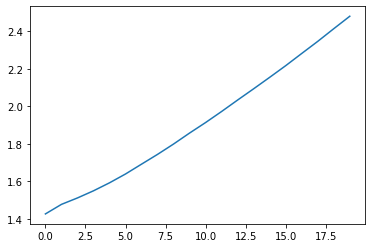

In [ ]:
model = umodel

# model.load_state_dict(torch.load(model_name))

sgd = optim.SGD(model.parameters(), lr=args.lr)


advloss, advacc = eval_adv_test(model, device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

In [ ]:
tesloss, tesacc = eval_test(fnn, device, test_loader)
print('test_loss: {:.4f}, trn_acc: {:.2f}%'.format(tesloss, 100. * tesacc), end='\n')

test_loss: 1.3276, trn_acc: 55.52%


0 misclassified: 96
1 misclassified: 90
2 misclassified: 87
3 misclassified: 88
4 misclassified: 95
5 misclassified: 90
6 misclassified: 91
7 misclassified: 85
8 misclassified: 104
9 misclassified: 92
10 misclassified: 91
11 misclassified: 94
12 misclassified: 92
13 misclassified: 96
14 misclassified: 89
15 misclassified: 86
16 misclassified: 80
17 misclassified: 88
18 misclassified: 88
19 misclassified: 97
20 misclassified: 91
21 misclassified: 94
22 misclassified: 91
23 misclassified: 89
24 misclassified: 98
25 misclassified: 95
26 misclassified: 93
27 misclassified: 95
28 misclassified: 82
29 misclassified: 90
30 misclassified: 97
31 misclassified: 98
32 misclassified: 97
33 misclassified: 91
34 misclassified: 86
35 misclassified: 90
36 misclassified: 82
37 misclassified: 99
38 misclassified: 101
39 misclassified: 98
40 misclassified: 99
41 misclassified: 88
42 misclassified: 80
43 misclassified: 88
44 misclassified: 92
45 misclassified: 101
46 misclassified: 90
47 misclassified: 81

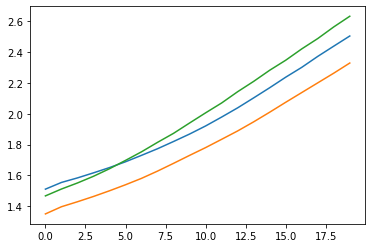

In [ ]:
model = umodel

# model.load_state_dict(torch.load(model_name))

sgd = optim.SGD(model.parameters(), lr=args.lr)


advloss, advacc = eval_adv_test(model, device, train_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

# Attack Benchmark

In [ ]:
!pip install --quiet torchattacks

In [22]:
import torchattacks

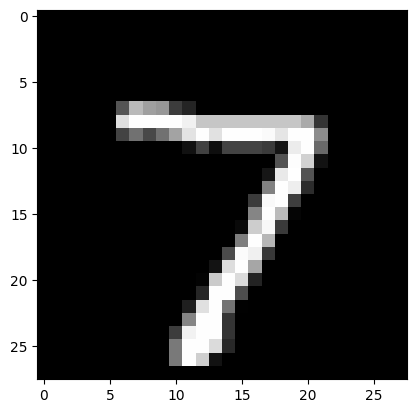

In [25]:
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:
    plt.imshow(data[0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [36]:
atk = torchattacks.SparseFool(fnn)
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:
      data, target = data.to(device), target.to(device)
      data = data.view(data.size(0), 28 * 28)
      atk.save(data_loader=[(data, target)], save_path="_transfer.pt")
      adv_data = atk(data, target)
      saliency = IntegratedGradients(fnn)
      audit2 = saliency.attribute(adv_data, target=target)

- Save progress: 100.00 % / Robust accuracy: 7.03 % / L2: nan (88.486 it/s) 	


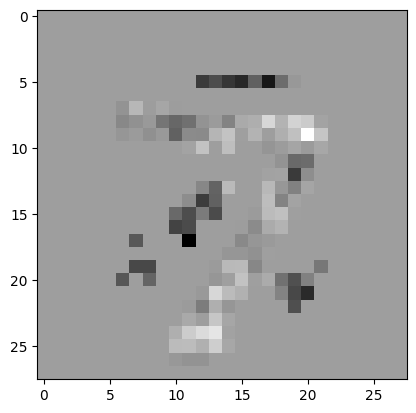

In [37]:
plt.imshow(audit2[0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [42]:
#@title XAI Monitor(data vs SparseFool)
sim = nn.CosineSimilarity()(label[0], audit2)
sim = torch.nan_to_num(sim)
print(torch.mean(sim))

tensor(0.6067, device='cuda:0', dtype=torch.float64)




---



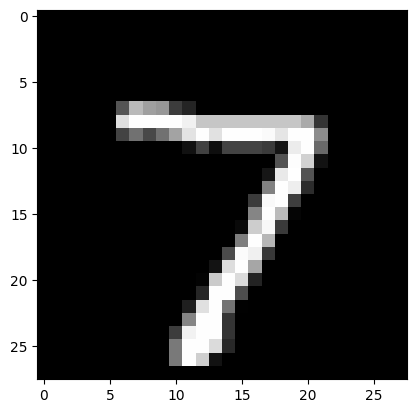

In [41]:
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:
    plt.imshow(data[0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [23]:
from copy import deepcopy

In [58]:
atk = torchattacks.SINIFGSM(fnn, steps=20)
audit2 = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    targetx = deepcopy(target)
    data = data.view(data.size(0), 28*28)
    target = target.view(128,1).repeat(1,10)
    #atk.save(data_loader=[(data, target)], save_path="_transfer.pt")
    #adv_data = atk(data, target)
    atk.save(data_loader=[(data, targetx)], save_path="_transfer.pt")
    adv_data = atk(data, target.to(torch.float32))
    saliency = IntegratedGradients(fnn)
    audit2.append(saliency.attribute(adv_data, target=targetx))

- Save progress: 100.00 % / Robust accuracy: 49.22 % / L2: 0.63092 (0.257 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 51.56 % / L2: 0.62969 (0.266 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 49.22 % / L2: 0.61926 (0.204 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 46.88 % / L2: 0.63106 (0.179 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 47.66 % / L2: 0.63337 (0.157 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 46.88 % / L2: 0.62930 (0.248 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 52.34 % / L2: 0.63325 (0.251 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 45.31 % / L2: 0.63068 (0.242 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 49.22 % / L2: 0.62931 (0.238 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 52.34 % / L2: 0.63114 (0.309 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 46.88 % / L2: 0.63040 (0.163 it/s) 	
- Save progress: 100.00 % / Robust accuracy: 44.53 % / L2: 0.63034 (0.162 it/s) 	
- Save progress:

In [57]:
print(len(audit2))

78


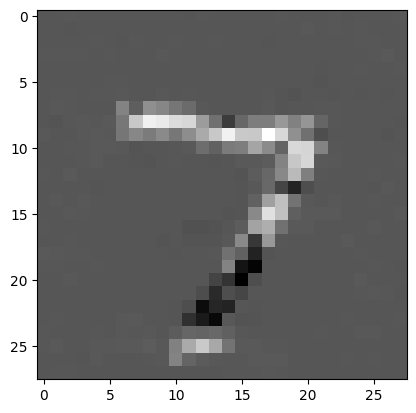

In [60]:
plt.imshow(audit2[0][0,:].cpu().detach().numpy().reshape((28,28)), cmap='gray')

In [68]:
#@title XAI Monitor(data vs SINIFGSM)
sim = 0
for i in range(len(audit2)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit2[i]))
print((sim)/len(audit2))

tensor(0.9430, dtype=torch.float64)


# Transfer

In [21]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 784, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(28*28, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        #x = x.reshape(1,3,512,1024)
        x = self.features(x)
        x = x.view(x.size(0), 28*28)
        x = self.classifier(x)
        return x

In [22]:
def eval_testX(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    idx = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            #print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            idx += 1

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [30]:
alex = AlexNet().to(device)

In [24]:
def train_alex(model, epochs=1):
	model = model.to(device)
 
	for epoch in range(1, epochs+1):
		start_time = time.time()
		sgd = optim.SGD(model.parameters(), lr=args.lr)
  
		trainX(args, model, device, train_loader, sgd, epoch)

		trnloss, trnacc = eval_testX(model, device, train_loader)

		print('Epoch ' + str(epoch) + ': ' + str(int(time.time() - start_time)) + 's', end=', ')
		print('trn_loss: {:.4f}, trn_acc: {:.2f}%'.format(trnloss, 100. * trnacc), end='\n')

	return model

In [25]:
from IPython.utils.path import target_update
def trainX(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
  
        # clear gradients
        optimizer.zero_grad()

        loss = F.cross_entropy(model(data), target)

        # get gradients and update
        loss.backward()
        optimizer.step()

In [81]:
alex = train_alex(alex)
alex.eval()

Epoch 1: 15s, trn_loss: 2.3019, trn_acc: 9.83%


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 784, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inp

In [38]:
umodel = UNet().to(device)
umodel.load_state_dict(torch.load('/content/drive/MyDrive/FYP/u1.1030278996743863.pt'))

<All keys matched successfully>

In [39]:
def pgd_whitebox(bi, model, X, mask, y, epsilon=args.epsilon, num_steps=args.num_steps, step_size=args.step_size, device=device):

	X_pgd = Variable(X.data, requires_grad=True)
 
	if args.random: 
		noise = torch.clamp(mask, -epsilon, epsilon).to(device) # XAI mask
		X_pgd = Variable(X_pgd.data + noise, requires_grad=True)
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = F.cross_entropy(model(X_pgd), y)
			if not bi % 200: lss.append(loss.item())
		loss.backward()

		eta = torch.clamp(mask, -step_size, step_size) * X_pgd.grad.data.sign() #grad for patch only # XAI mask based pixel wise step size
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
	et = time.time()
	#print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	if not bi % 200: plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')
	return X_pgd

In [40]:
def transfer_adv_test(model, device, test_loader):

    model.eval().to(device)
    fnn.eval().to(device)
    alex.eval().to(device)
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            buf = model(data)
            adv = pgd_whitebox(batch_idx, fnn, data.view(data.size(0), 28*28), buf.view(buf.size(0), 28*28), target, device=device)
            output = alex(adv.view(adv.size(0), 1, 28, 28))
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

0 misclassified: 116
1 misclassified: 118
2 misclassified: 119
3 misclassified: 115
4 misclassified: 115
5 misclassified: 119
6 misclassified: 117
7 misclassified: 116
8 misclassified: 119
9 misclassified: 117
10 misclassified: 116
11 misclassified: 118
12 misclassified: 115
13 misclassified: 121
14 misclassified: 113
15 misclassified: 110
16 misclassified: 113
17 misclassified: 121
18 misclassified: 118
19 misclassified: 115
20 misclassified: 118
21 misclassified: 109
22 misclassified: 119
23 misclassified: 113
24 misclassified: 114
25 misclassified: 116
26 misclassified: 109
27 misclassified: 117
28 misclassified: 116
29 misclassified: 116
30 misclassified: 116
31 misclassified: 115
32 misclassified: 120
33 misclassified: 121
34 misclassified: 116
35 misclassified: 114
36 misclassified: 115
37 misclassified: 118
38 misclassified: 117
39 misclassified: 116
40 misclassified: 115
41 misclassified: 117
42 misclassified: 113
43 misclassified: 119
44 misclassified: 115
45 misclassified: 11

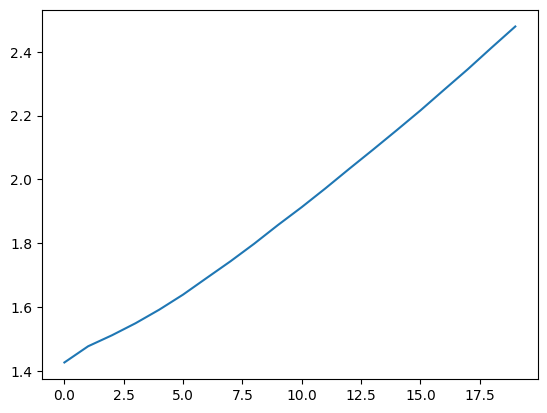

In [82]:
model = umodel

# model.load_state_dict(torch.load(model_name))

sgd = optim.SGD(model.parameters(), lr=args.lr)


advloss, advacc = transfer_adv_test(model, device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

## eva kernel

In [ ]:
!pip install --quiet torchshow

In [ ]:
import torchshow as ts

In [ ]:
for name, layer in umodel.named_modules():
  if isinstance(layer, torch.nn.Conv2d):
    print(name, layer, layer.weight)
    ts.save(layer.weight)

encoder.enc_blocks.0.conv1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Parameter containing:
tensor([[[[ 4.3355e-03, -1.4336e-02, -1.2797e-02],
          [ 5.1678e-03,  1.1321e-02,  9.1521e-04],
          [ 8.1122e-03, -6.0914e-03, -1.5950e-02]],

         [[-5.1129e-03, -2.1516e-02, -1.1083e-02],
          [ 6.5492e-03,  1.8093e-03, -1.0439e-02],
          [ 6.8852e-03, -3.0762e-04,  1.1994e-02]],

         [[ 8.9396e-03, -2.2709e-03,  9.0533e-03],
          [-8.1659e-03,  3.8766e-03,  7.1023e-03],
          [ 6.2679e-03,  1.9559e-03, -8.3238e-04]]],


        [[[-3.7152e-03,  8.7421e-03,  2.2367e-03],
          [-1.4222e-02, -3.8915e-04, -2.6502e-03],
          [-4.1332e-03, -6.5362e-03,  1.2438e-02]],

         [[ 8.6501e-03, -2.8996e-03, -1.8476e-02],
          [-7.0091e-03, -6.0769e-03,  7.8099e-03],
          [-6.3846e-03, -1.7754e-02,  1.0387e-02]],

         [[-6.0317e-03, -9.4767e-03, -1.1416e-02],
          [ 4.1689e-03, -1.9137e-03, -3.1358e-03],
       

In [ ]:
!zip -r ukts.zip /content/_torchshow

  adding: content/_torchshow/ (stored 0%)
  adding: content/_torchshow/2023-03-23_08-33-54-007447.png (deflated 11%)
  adding: content/_torchshow/2023-03-23_08-34-32-867741.png (deflated 7%)
  adding: content/_torchshow/2023-03-23_08-34-30-548266.png (deflated 8%)
  adding: content/_torchshow/2023-03-23_08-34-24-311029.png (deflated 8%)
  adding: content/_torchshow/2023-03-23_08-33-24-724381.png (deflated 19%)
  adding: content/_torchshow/2023-03-23_08-34-18-005787.png (deflated 14%)
  adding: content/_torchshow/2023-03-23_08-34-03-004560.png (deflated 11%)
  adding: content/_torchshow/2023-03-23_08-34-06-599184.png (deflated 18%)
  adding: content/_torchshow/2023-03-23_08-34-27-501956.png (deflated 8%)
  adding: content/_torchshow/2023-03-23_08-33-30-833083.png (deflated 9%)
  adding: content/_torchshow/2023-03-23_08-33-26-711661.png (deflated 7%)
  adding: content/_torchshow/2023-03-23_08-33-37-644980.png (deflated 9%)
  adding: content/_torchshow/2023-03-23_08-34-33-263935.png (stor